# **Desafio Manutenção Preventiva**

**Objetivo:** Construir modelo preditivo para prever RUL das máquinas em operação de forma a otimizar os custos com manutenção.

**Nome:** Arthur Guimarães Yuan


In [ ]:
pip install shap

In [ ]:
import pandas as pd
import numpy as np 

# Visualização
from matplotlib import pyplot as plt
from matplotlib import style
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# sklearn
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
%matplotlib inline

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving PM_test.txt to PM_test.txt
Saving PM_train.txt to PM_train.txt
Saving RUL_FD001.txt to RUL_FD001.txt


Carregando e tratando os dados

In [ ]:
# Dataset de treino
df_maintenance = pd.read_csv('PM_train.txt',delimiter= ' ',  header = None)
df_maintenance.drop(columns=[26,27], inplace= True)

# Dataset de teste
df_test = pd.read_csv('PM_test.txt',delimiter= ' ',  header = None)
df_test.drop(columns=[26,27], inplace= True)

In [ ]:
# Renomeando as colunas

df_maintenance.columns= ['asset_id','runtime','setting1', 'setting2','setting3',
                         'tag1','tag2','tag3','tag4','tag5','tag6','tag7','tag8','tag9','tag10',
                         'tag11','tag12','tag13','tag14','tag15','tag16','tag17','tag18','tag19','tag20',
                         'tag21']

df_test.columns= ['asset_id','runtime','setting1', 'setting2','setting3',
                         'tag1','tag2','tag3','tag4','tag5','tag6','tag7','tag8','tag9','tag10',
                         'tag11','tag12','tag13','tag14','tag15','tag16','tag17','tag18','tag19','tag20',
                         'tag21']

In [ ]:
# Transformando a variável asset em string
df_maintenance['asset_id'] = df_maintenance.asset_id.astype(str)

#**Explorando os Dados**

**Verificando a feature runtime (ciclos)**

In [ ]:
# Verificando a quantidade máxima de execução de cada ativo até sua falha
max_runtime_asset = df_maintenance.groupby('asset_id').runtime.max().rename('max_runtime').reset_index()

In [ ]:
max_runtime_asset.max_runtime.describe().reset_index()

,index,max_runtime
0,count,100.000000
1,mean,206.310000
2,std,46.342749
3,min,128.000000
4,25%,177.000000
5,50%,199.000000
6,75%,229.250000
7,max,362.000000


In [ ]:
# Verificando a distribuição dos valores máximos de cada asset
fig = px.histogram(max_runtime_asset, x="max_runtime")
fig.show()

In [ ]:
# Observando o boxplot da distribuição
fig = px.box(max_runtime_asset, y="max_runtime")
fig.show()

In [ ]:
# Verificando os assets que são outliers
max_runtime_asset[max_runtime_asset['max_runtime'] > 293]

,asset_id,max_runtime
64,67,313
66,69,362
92,92,341
96,96,336


**Verificando as features settings**

In [ ]:
df_maintenance[['setting1','setting2','setting3']].describe()

,setting1,setting2,setting3
count,20631.000000,20631.000000,20631.0
mean,-0.000009,0.000002,100.0
std,0.002187,0.000293,0.0
min,-0.008700,-0.000600,100.0
25%,-0.001500,-0.000200,100.0
50%,0.000000,0.000000,100.0
75%,0.001500,0.000300,100.0
max,0.008700,0.000600,100.0


Observa-se que a feature setting3 não tem variação, logo essa coluna não tem informação relevante para o modelo

In [ ]:
# Verificando a distribuição da feature setting1
fig = px.histogram(df_maintenance, x="setting1")
fig.show()

In [ ]:
# Verificando a distribuição da feature setting2
fig = px.histogram(df_maintenance, x="setting2")
fig.show()

Pelo desvio padrão de setting1 e setting2 ser muito pequeno e que não existe variação em setting3, assume-se que todos os ativos possuem a mesma configuração durante os ciclos, ou seja, o valor desses atributos não interfere na predição do modelo. 

**Verficando os sensores**

In [ ]:
fig = make_subplots(rows=11, cols=2,
                    subplot_titles=("tag1", "tag2", "tag3", "tag4",
                                    "tag5","tag6","tag7","tag8"))

fig.add_trace(
    go.Scatter(x=df_maintenance['runtime'], y=df_maintenance['tag1'],mode='markers'), row=1, col=1
)

fig.add_trace(
    go.Scatter(x=df_maintenance['runtime'], y=df_maintenance['tag2'],mode='markers'),row=1, col=2
)

fig.add_trace(
    go.Scatter(x=df_maintenance['runtime'], y=df_maintenance['tag3'],mode='markers'), row=2, col=1
)

fig.add_trace(
    go.Scatter(x=df_maintenance['runtime'], y=df_maintenance['tag4'],mode='markers'),row=2, col=2
)

fig.add_trace(
    go.Scatter(x=df_maintenance['runtime'], y=df_maintenance['tag5'],mode='markers'), row=3, col=1
)

fig.add_trace(
    go.Scatter(x=df_maintenance['runtime'], y=df_maintenance['tag6'],mode='markers'),row=3, col=2
)

fig.add_trace(
    go.Scatter(x=df_maintenance['runtime'], y=df_maintenance['tag7'],mode='markers'), row=4, col=1
)

fig.add_trace(
    go.Scatter(x=df_maintenance['runtime'], y=df_maintenance['tag8'],mode='markers'),row=4, col=2
)

fig.update_layout(height=2000, width=1500, title_text="Sensores")
fig.show()

In [ ]:
fig = make_subplots(rows=11, cols=2,
                    subplot_titles=("tag9", "tag10", "tag11", "tag12",
                                    "tag13","tag14","tag15","tag16"))

fig.add_trace(
    go.Scatter(x=df_maintenance['runtime'], y=df_maintenance['tag9'],mode='markers'), row=1, col=1
)

fig.add_trace(
    go.Scatter(x=df_maintenance['runtime'], y=df_maintenance['tag10'],mode='markers'),row=1, col=2
)

fig.add_trace(
    go.Scatter(x=df_maintenance['runtime'], y=df_maintenance['tag11'],mode='markers'), row=2, col=1
)

fig.add_trace(
    go.Scatter(x=df_maintenance['runtime'], y=df_maintenance['tag12'],mode='markers'),row=2, col=2
)

fig.add_trace(
    go.Scatter(x=df_maintenance['runtime'], y=df_maintenance['tag13'],mode='markers'), row=3, col=1
)

fig.add_trace(
    go.Scatter(x=df_maintenance['runtime'], y=df_maintenance['tag14'],mode='markers'),row=3, col=2
)

fig.add_trace(
    go.Scatter(x=df_maintenance['runtime'], y=df_maintenance['tag15'],mode='markers'), row=4, col=1
)

fig.add_trace(
    go.Scatter(x=df_maintenance['runtime'], y=df_maintenance['tag16'],mode='markers'),row=4, col=2
)

fig.update_layout(height=2000, width=1500, title_text="Sensores")
fig.show()

In [ ]:
fig = make_subplots(rows=3, cols=2,
                    subplot_titles=("tag17", "tag18", "tag19", "tag20",
                                    "tag21"))

fig.add_trace(
    go.Scatter(x=df_maintenance['runtime'], y=df_maintenance['tag17'],mode='markers'), row=1, col=1
)

fig.add_trace(
    go.Scatter(x=df_maintenance['runtime'], y=df_maintenance['tag18'],mode='markers'),row=1, col=2
)

fig.add_trace(
    go.Scatter(x=df_maintenance['runtime'], y=df_maintenance['tag19'],mode='markers'), row=2, col=1
)

fig.add_trace(
    go.Scatter(x=df_maintenance['runtime'], y=df_maintenance['tag20'],mode='markers'),row=2, col=2
)

fig.add_trace(
    go.Scatter(x=df_maintenance['runtime'], y=df_maintenance['tag21'],mode='markers'), row=3, col=1
)


fig.update_layout(height=1000, width=1500, title_text="Sensores")
fig.show()

Verificando os gráfico apresentados acima,observa-se que alguns sensores não tem correlação com os ciclos, logo não são relavantes para usar em modelo de predição.

Sensores sem correlação:
- 1,5,6,10,16,18,19

Sensores com correlação:
- 2,3,4,7,8,9,11,12,13,14,15,17,20,21


#**Preparação dos dados**

Como verificado no boxplot anterior, os valores máximos do runtime estão distribuídos entre 128 até 293. Desta forma, a primeira hipótese levantada é que os ativos têm no mínimo 128 ciclos e partir disso começam a apresentar. Essa informação pode ser verificada nos gráficos dos sensores que possuem correlação com o tempo, no qual começam a variar após um período constante.

In [ ]:
# Utilizando apenas os dados após o período de 128 ciclos
df_maintenance = df_maintenance[df_maintenance['runtime'] > 128]

#  Pegando o valor máximo de cada asset para calcular o RUL
df_maintenance = pd.merge(df_maintenance,max_runtime_asset, on='asset_id', how = 'left')
df_maintenance['rul'] = df_maintenance.apply(lambda x: x['max_runtime'] - x['runtime'], axis=1)

In [ ]:
# Separando as features relevantes para o modelo
df_train = df_maintenance.drop(columns= ['asset_id','runtime','setting1','setting2','setting3',
                                         'tag1','tag5','tag6','tag10','tag16','tag18','tag19',
                                         'max_runtime'])

In [ ]:
# Preparando os dados de teste
df_test = df_test.groupby('asset_id').last().reset_index()

X_test = df_test.drop(columns= ['asset_id','runtime','setting1','setting2','setting3',
                        'tag1','tag5','tag6','tag10','tag16','tag18','tag19'])

In [ ]:
# Separando o valor target do dataframe
X = df_train.drop(columns='rul')
Y = df_train['rul']

In [ ]:
# Separando os dados em valores de treino e teste
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, train_size=0.7, test_size=0.3,
                                                      random_state=0)

In [ ]:
# Padronizando os valores dos sensores escolhidos para a mesma escala
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_valid)

#**Treinando o modelo**

Para este dataset foi escolhido três modelos de algoritmos que possuem métodos diferentes para regressão. Os modelos são:

- Linear Regression
- ExtraTreesRegressor
- GradientBoostingRegressor

Para avaliar as perfomances do modelos vão ser utilizadas três métricas que são:

- R2 Score: verifica a variança dos dados que é explicado pelo modelo
- MAE: verifica o erro médio das predições do modelo
- RMSE: verifica o erro quadrático médio, ou seja, erros maiores tem pesos maiores no cálculo

**Linear Regression**

In [ ]:
from sklearn.linear_model import LinearRegression

lreg = LinearRegression().fit(X_train, y_train)
Y_lreg_prediction = lreg.predict(X_valid)

print("MAE:", mean_absolute_error(y_valid, Y_lreg_prediction))
print("RMSE:", mean_squared_error(y_valid, Y_lreg_prediction, squared= False))
print("R2", r2_score(y_valid, Y_lreg_prediction))

MAE: 17.164849352391407
RMSE: 23.530933380030838
R2 0.6640797313237464


**ExtraTreesRegressor**

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor

et_reg = ExtraTreesRegressor(n_estimators=100, random_state=0).fit(X_train, y_train)
Y_et_reg_prediction = et_reg.predict(X_valid)

print("MAE:", mean_absolute_error(y_valid, Y_et_reg_prediction))
print("RMSE:", mean_squared_error(y_valid, Y_et_reg_prediction, squared= False))
print("R2", r2_score(y_valid, Y_et_reg_prediction))

MAE: 13.729902127659573
RMSE: 20.519168413534178
R2 0.7445667598192227


**GradientBoostingRegressor**

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
# Testando o modelo ExtraTree Regressor
gb_reg = GradientBoostingRegressor(random_state=0).fit(X_train, y_train)
Y_gb_reg_prediction = gb_reg.predict(X_valid)

print("MAE:", mean_absolute_error(y_valid, Y_gb_reg_prediction))
print("RMSE:", mean_squared_error(y_valid, Y_gb_reg_prediction, squared= False))
print("R2", r2_score(y_valid, Y_gb_reg_prediction))

MAE: 14.12307781156939
RMSE: 21.04656490924784
R2 0.7312674045632972


O modelo que apresentou melhor perfomance foi o ExtraTreeRegressor

**Feature selection**

Verificando as features mais importantes para o modelo e se a exclusão das menos relevantes impacta na perfomance. Para isto, irei usar o modelo de RandomForest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
RF_reg = RandomForestRegressor().fit(X_train, y_train)

# Verificando as preditoras mais importantes
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(RF_reg.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances

,importance
feature,
tag11,0.504
tag9,0.128
tag4,0.058
tag14,0.045
tag15,0.045
tag12,0.043
tag7,0.035
tag2,0.026
tag8,0.025


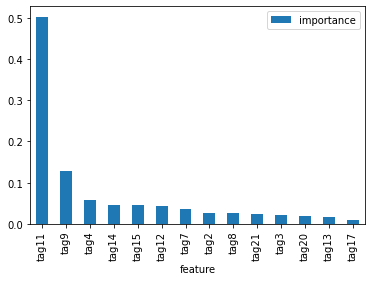

In [ ]:
importances.plot.bar()

Removendo o sensores com 0.02 para verificar se melhora a qualidade do modelo 

In [ ]:
df_train_new = df_train.drop(columns= ['tag21','tag3','tag20','tag13','tag17'])
X_test_new  = X_test.drop(columns= ['tag21','tag3','tag20','tag13','tag17'])

In [ ]:
# Separando novamente os dados da variável target
X2 = df_train_new.drop(columns='rul')
Y2 = df_train_new['rul']

# Separando os dados em valores de treino e teste
X_train2, X_valid2, y_train2, y_valid2 = train_test_split(X2, Y2, train_size=0.7, test_size=0.3,
                                                      random_state=0)

In [ ]:
# Padronizando os dados 
scaler = MinMaxScaler()
scaler.fit(X_train2)
X_train_scaled2 = scaler.transform(X_train2)
X_test_scaled2 = scaler.transform(X_valid2)

In [ ]:
# Testando o modelo ExtraTree Regressor
et_reg2 = ExtraTreesRegressor(n_estimators=100, random_state=0).fit(X_train2, y_train2)
Y_et_reg_prediction2 = et_reg2.predict(X_valid2)

print("MAE:", mean_absolute_error(y_valid2, Y_et_reg_prediction2))
print("RMSE:", mean_squared_error(y_valid2, Y_et_reg_prediction2, squared= False))
print("R2", r2_score(y_valid2, Y_et_reg_prediction2))

MAE: 14.138170212765957
RMSE: 21.137492755764576
R2 0.7289403682630364


Retirando as features de menor importância acabou impactando negativamente a perfomance do modelo, logo não será usado.

**Verificando multicolinearidade entre as features**

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

df_maintenance_VIF = df_maintenance.drop(columns=['asset_id','runtime','setting1'
                                        ,'setting2','setting3','max_runtime','rul']).copy()


# VIF 
vif_data = pd.DataFrame()
vif_data["feature"] = df_maintenance_VIF.columns
  
# Calculando VIF para cada feature
vif_data["VIF"] = [variance_inflation_factor(df_maintenance_VIF.values, i)
                          for i in range(len(df_maintenance_VIF.columns))]

vif_data["VIF"] = round(vif_data["VIF"],2)
print(vif_data)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1636: RuntimeWarning:

divide by zero encountered in double_scalars



   feature    VIF
0     tag1   0.00
1     tag2   2.44
2     tag3   2.14
3     tag4   4.10
4     tag5   0.00
5     tag6   1.01
6     tag7   4.02
7     tag8   4.69
8     tag9  33.28
9    tag10   0.00
10   tag11   5.26
11   tag12   4.71
12   tag13   4.63
13   tag14  33.27
14   tag15   3.08
15   tag16   0.00
16   tag17   2.35
17   tag18   0.00
18   tag19   0.00
19   tag20   2.82
20   tag21   2.84


Observa-se que as Tag9 e Tag14 apresentam um valor VIF maior do que 10, considerado o valor máximo. Vou remover essas duas variáveis para verificar como o modelo se comporta.

In [ ]:
df_train_new = df_train.drop(columns= ['tag9','tag14'])
X_test_new  = X_test.drop(columns= ['tag9','tag14'])

# Separando novamente os dados da variável target
X2 = df_train_new.drop(columns='rul')
Y2 = df_train_new['rul']

# Separando os dados em valores de treino e teste
X_train2, X_valid2, y_train2, y_valid2 = train_test_split(X2, Y2, train_size=0.7, test_size=0.3,
                                                      random_state=0)

# Testando o modelo ExtraTree Regressor
et_reg2 = ExtraTreesRegressor(n_estimators=100, random_state=0).fit(X_train2, y_train2)
Y_et_reg_prediction2 = et_reg2.predict(X_valid2)

print("MAE:", mean_absolute_error(y_valid2, Y_et_reg_prediction2))
print("RMSE:", mean_squared_error(y_valid2, Y_et_reg_prediction2, squared= False))
print("R2", r2_score(y_valid2, Y_et_reg_prediction2))

MAE: 16.8249914893617
RMSE: 23.871291071164443
R2 0.6542917711929459


Ao remover as features com alta valor de VIF o modelo perdeu perfomance, desta forma irei manter o primeiro modelo para fazer a predição dos valores de teste.

**ExtraTreeRegressor Tuning**

Para encontrar os melhores hiperparâmetros irei utilizar o RandomizedSearchCV.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'max_depth': [10, 20, 30, 40],
    'max_features': ['auto', 'sqrt','log2'],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 4, 6],
    'n_estimators': [500, 700, 1000]
}
rf = ExtraTreesRegressor()
rf_random =  RandomizedSearchCV(estimator = rf, param_distributions = param_grid, n_iter = 50, cv = 3, verbose=2, random_state=42, n_jobs = -1)


In [ ]:
random_result = rf_random.fit(X_train, y_train)
random_result

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  7.6min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0,
                                                 criterion='mse',
                                                 max_depth=None,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 max_samples=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100, n_jobs=None,
                                                 oob_score=False,
                         

In [ ]:
rf_random.best_params_

{'max_depth': 30,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 700}

Recalculando o modelo novamente com os parâmetros encontrados.

In [ ]:
et_reg = ExtraTreesRegressor(**rf_random.best_params_).fit(X_train, y_train)
Y_et_reg_prediction = et_reg.predict(X_valid)

print("MAE:", mean_absolute_error(y_valid, Y_et_reg_prediction))
print("RMSE:", mean_squared_error(y_valid, Y_et_reg_prediction, squared= False))
print("R2", r2_score(y_valid, Y_et_reg_prediction))

MAE: 13.690474353741497
RMSE: 20.452570806886374
R2 0.7462221520867571


Houve uma pequena melhora em relação ao modelo anterior, para conseguir melhores parâmetros uma outra solução seria aumentar os "param_grid" do Random Search ou utilizar o GridSearchCV, porém por falta de poder computacional, não seguirei com este procedimento.

**Prevendo os valores de Teste**

In [ ]:
Y_prediction = et_reg.predict(X_test)

In [ ]:
Y_prediction = list(Y_prediction)

In [ ]:
test_asset = list(df_test.asset_id.unique())

In [ ]:
df_predictions = pd.DataFrame({'asset_id':test_asset,'RUL':Y_prediction})

In [ ]:
df_predictions['maintenance'] = df_predictions['RUL'].apply(lambda x: 'SIM' if (x-20) < 0 else 'NÃO')

In [ ]:
df_predictions.sort_values(by='RUL')

,asset_id,RUL,maintenance
33,34,6.78,SIM
34,35,8.67,SIM
80,81,8.87,SIM
81,82,9.35,SIM
75,76,13.41,SIM
...,...,...,...
94,95,141.91,NÃO
77,78,142.18,NÃO
22,23,149.14,NÃO
0,1,150.17,NÃO


In [ ]:
results = pd.DataFrame({'predicted': Y_prediction})
from google.colab import files
results.to_csv('regressao_<arthur_yuan>.csv')
files.download('regressao_<arthur_yuan>.csv')

**Conclusão**

Modelo utilizado: ExtraTreesRegressor

Métricas de avaliação:

- MAE: 13.690474353741497

- RMSE: 20.452570806886374

- R2 0.7462221520867571

Predições: arquivo enviado por e-mail.

**Implementação do modelo**

O código mostrao abaixo se refere a implementação do modelo proposto na apresentação. De forma a indicar os sensores que mais influenciam no valor de RUL é utilizado a biblioteca SHAP.

Para a aplicação web foi utilizado o Streamlit, o código foi escrito no Pycharm, pois não roda no jupyter notebook, porém irei colocar o código aqui para mostrar como teria executado.

**SHAP**

In [ ]:
import shap
explainer = shap.TreeExplainer(et_reg, feature_perturbation='interventional')
shap_values = explainer.shap_values(X_test)

In [ ]:
shap.initjs()
# Verificação predição individualmente
asset=61
shap.force_plot(explainer.expected_value, shap_values[asset,:], X_valid.iloc[asset,:])

In [ ]:
# Colocando o nome dos sensores usados em uma lista
sensor= ['tag2','tag3','tag4','tag7','tag8','tag9','tag11',
          'tag12','tag13','tag14','tag15','tag17','tag20','tag21']

In [ ]:
preditores = shap_values[asset,:]

In [ ]:
preditores

array([ 2.40409758e-01, -6.67843792e-01,  5.45851763e+00,  4.89594689e+00,
        2.43439680e+00, -1.18515654e+01,  7.62691084e+00,  1.69477910e+00,
        6.37547453e-01, -6.41468659e+00, -1.57517113e+00, -7.65795484e-03,
        2.65386556e-01,  5.98882321e-01])

In [ ]:
df_shap = pd.DataFrame({'sensor':sensor,'feature_strengh': preditores})

In [ ]:
df_shap.sort_values(by='feature_strengh')

,sensor,feature_strengh
5,tag9,-11.851565
9,tag14,-6.414687
10,tag15,-1.575171
1,tag3,-0.667844
11,tag17,-0.007658
0,tag2,0.240410
12,tag20,0.265387
13,tag21,0.598882
8,tag13,0.637547
7,tag12,1.694779


In [ ]:
# Sensores com influência positiva
df_shap_positive = df_shap[df_shap['feature_strengh'] >= 1].copy()
df_shap_positive = df_shap_positive.sort_values(by='feature_strengh', ascending= False)

# Sensores com influência negativa
df_shap_negative = df_shap[df_shap['feature_strengh'] <= -1].copy()
df_shap_negative['feature_strengh'] = df_shap_negative['feature_strengh'].apply(lambda x: x*(-1))
df_shap_negative = df_shap_negative.sort_values(by='feature_strengh', ascending= False)

In [ ]:
df_shap_positive

,sensor,feature_strengh
5,tag9,2.197255
9,tag14,1.599433


In [ ]:
df_shap_negative

,sensor,feature_strengh
6,tag11,12.798942
3,tag7,7.004679
7,tag12,6.624080
10,tag15,5.385230
12,tag20,1.901909
4,tag8,1.647932
8,tag13,1.600734
0,tag2,1.565806
13,tag21,1.013438


In [ ]:
fig_positive = px.bar(df_shap_positive, x='sensor', y='feature_strengh')
fig_positive.show()

In [ ]:
fig_negative = px.bar(df_shap_negative, x='sensor', y='feature_strengh')
fig_negative.update_traces(marker_color='red')
fig_negative.show()

**STREAMLIT**

O código abaixo refere só a parte da aplicação web.

In [ ]:
image = Image.open('Capture.JPG')
col11, col22 = st.beta_columns([1, 19])
with col11:
    st.image(image, width=64)

with col22:
    st.title('Monitoramento de Ativos')

st.sidebar.write('''# Configurações''')
choice = st.sidebar.selectbox('Visualização',('Geral','Ativo'))

if choice == 'Geral':
    st.write('**Asset_id**: código do ativo')
    st.write('**RUL**: tempo de vida restante do ativo')
    st.write('**Maintenance**: se o ativo precisa de manutenção')

    col11, col22 = st.beta_columns([1, 2])
    with col11:
        st.dataframe(df_predictions.head(50),500,500)

    with col22:
        st.dataframe(df_predictions.tail(50),500,500)

elif choice == 'Ativo':
    n_asset = st.sidebar.selectbox('Asset',('61'))

    # SHAP
    explainer = shap.TreeExplainer(et_reg, feature_perturbation='interventional')
    shap_values = explainer.shap_values(X_test)
    asset = 61
    shap.force_plot(explainer.expected_value, shap_values[asset, :], X_valid.iloc[asset, :])

    # Colocando o nome dos sensores usados em uma lista
    sensor = ['tag2', 'tag3', 'tag4', 'tag7', 'tag8', 'tag9', 'tag11',
              'tag12', 'tag13', 'tag14', 'tag15', 'tag17', 'tag20', 'tag21']

    preditores = shap_values[asset, :]
    df_shap = pd.DataFrame({'sensor': sensor, 'feature_strengh': preditores})
    df_shap.sort_values(by='feature_strengh')

    # Sensores com influência positiva
    df_shap_positive = df_shap[df_shap['feature_strengh'] >= 1].copy()
    df_shap_positive = df_shap_positive.sort_values(by='feature_strengh', ascending=False)

    # Sensores com influência negativa
    df_shap_negative = df_shap[df_shap['feature_strengh'] <= -1].copy()
    df_shap_negative['feature_strengh'] = df_shap_negative['feature_strengh'].apply(lambda x: x * (-1))
    df_shap_negative = df_shap_negative.sort_values(by='feature_strengh', ascending=False)

    fig_positive = px.bar(df_shap_positive, x='sensor', y='feature_strengh')
    fig_negative = px.bar(df_shap_negative, x='sensor', y='feature_strengh')
    fig_negative.update_traces(marker_color='red')

    st.write('''# Visão Geral do sensores''')
    st.write('A seguir é mostrado saúde do ativo em relação aos sensores que estão acoplados')

    col11, col22 = st.beta_columns([1, 6])
    with col11:
        st.button('Reportar erro')

    with col22:
        st.button('Relatório')

    st.subheader('Sensores que estão indicando vida útil menor para o ativo')
    st.plotly_chart(fig_negative)

    st.subheader('Sensores que estão com valores saudáveis')
    st.plotly_chart(fig_positive)